# Импорты и загрузки

## Импорты

In [1]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.8 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest

from catboost import CatBoost, CatBoostClassifier
from catboost.utils import eval_metric
from catboost import Pool

import warnings
warnings.filterwarnings('ignore') 

STATE = np.random.RandomState(12345)

In [3]:
import zipfile
import requests
from urllib.parse import urlencode


In [4]:
k = 5
n_cells = 50
# n_cells = 333

## Загрузка данных из yandex.drive на виртуальный диск Colab

#### data.zip все *.csv появляются слева на вкладке

In [5]:

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('data.zip', 'wb') as f:   # Здесь укажите нужный путь к файлу
#     f.write(download_response.content)

# # Укажите путь к zip-архиву
# zip_path = '/content/data.zip'

# # Распаковка zip-архива
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall()

In [6]:
# response.json()

## Подготоавливаем словарь для корректной загрузки типов данных. По умолчанию загружается float64, мы используем float32

In [7]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

## Base dataset

In [8]:
df_base = pd.read_csv("/kaggle/input/datasets-for-matching/base.csv", index_col=0, dtype=dict_base)

df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


In [9]:
df_base.shape

(2918139, 72)

In [10]:
df_base[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


## Train dataset

In [11]:
df_train = pd.read_csv("/kaggle/input/datasets-for-matching/train.csv", index_col=0, dtype=dict_train)


df_train.shape

(100000, 73)

## Create index

In [12]:
dims = df_base.shape[1]
# n_cells = 333
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [13]:
idx_l2

<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7d480fac0840> >

In [14]:
idx_l2.train(np.ascontiguousarray(df_base.values[:20000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [15]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
#del df_base

## First model

In [16]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [17]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

9.044


## EDA

In [18]:
df_samples = df_train[:5000]

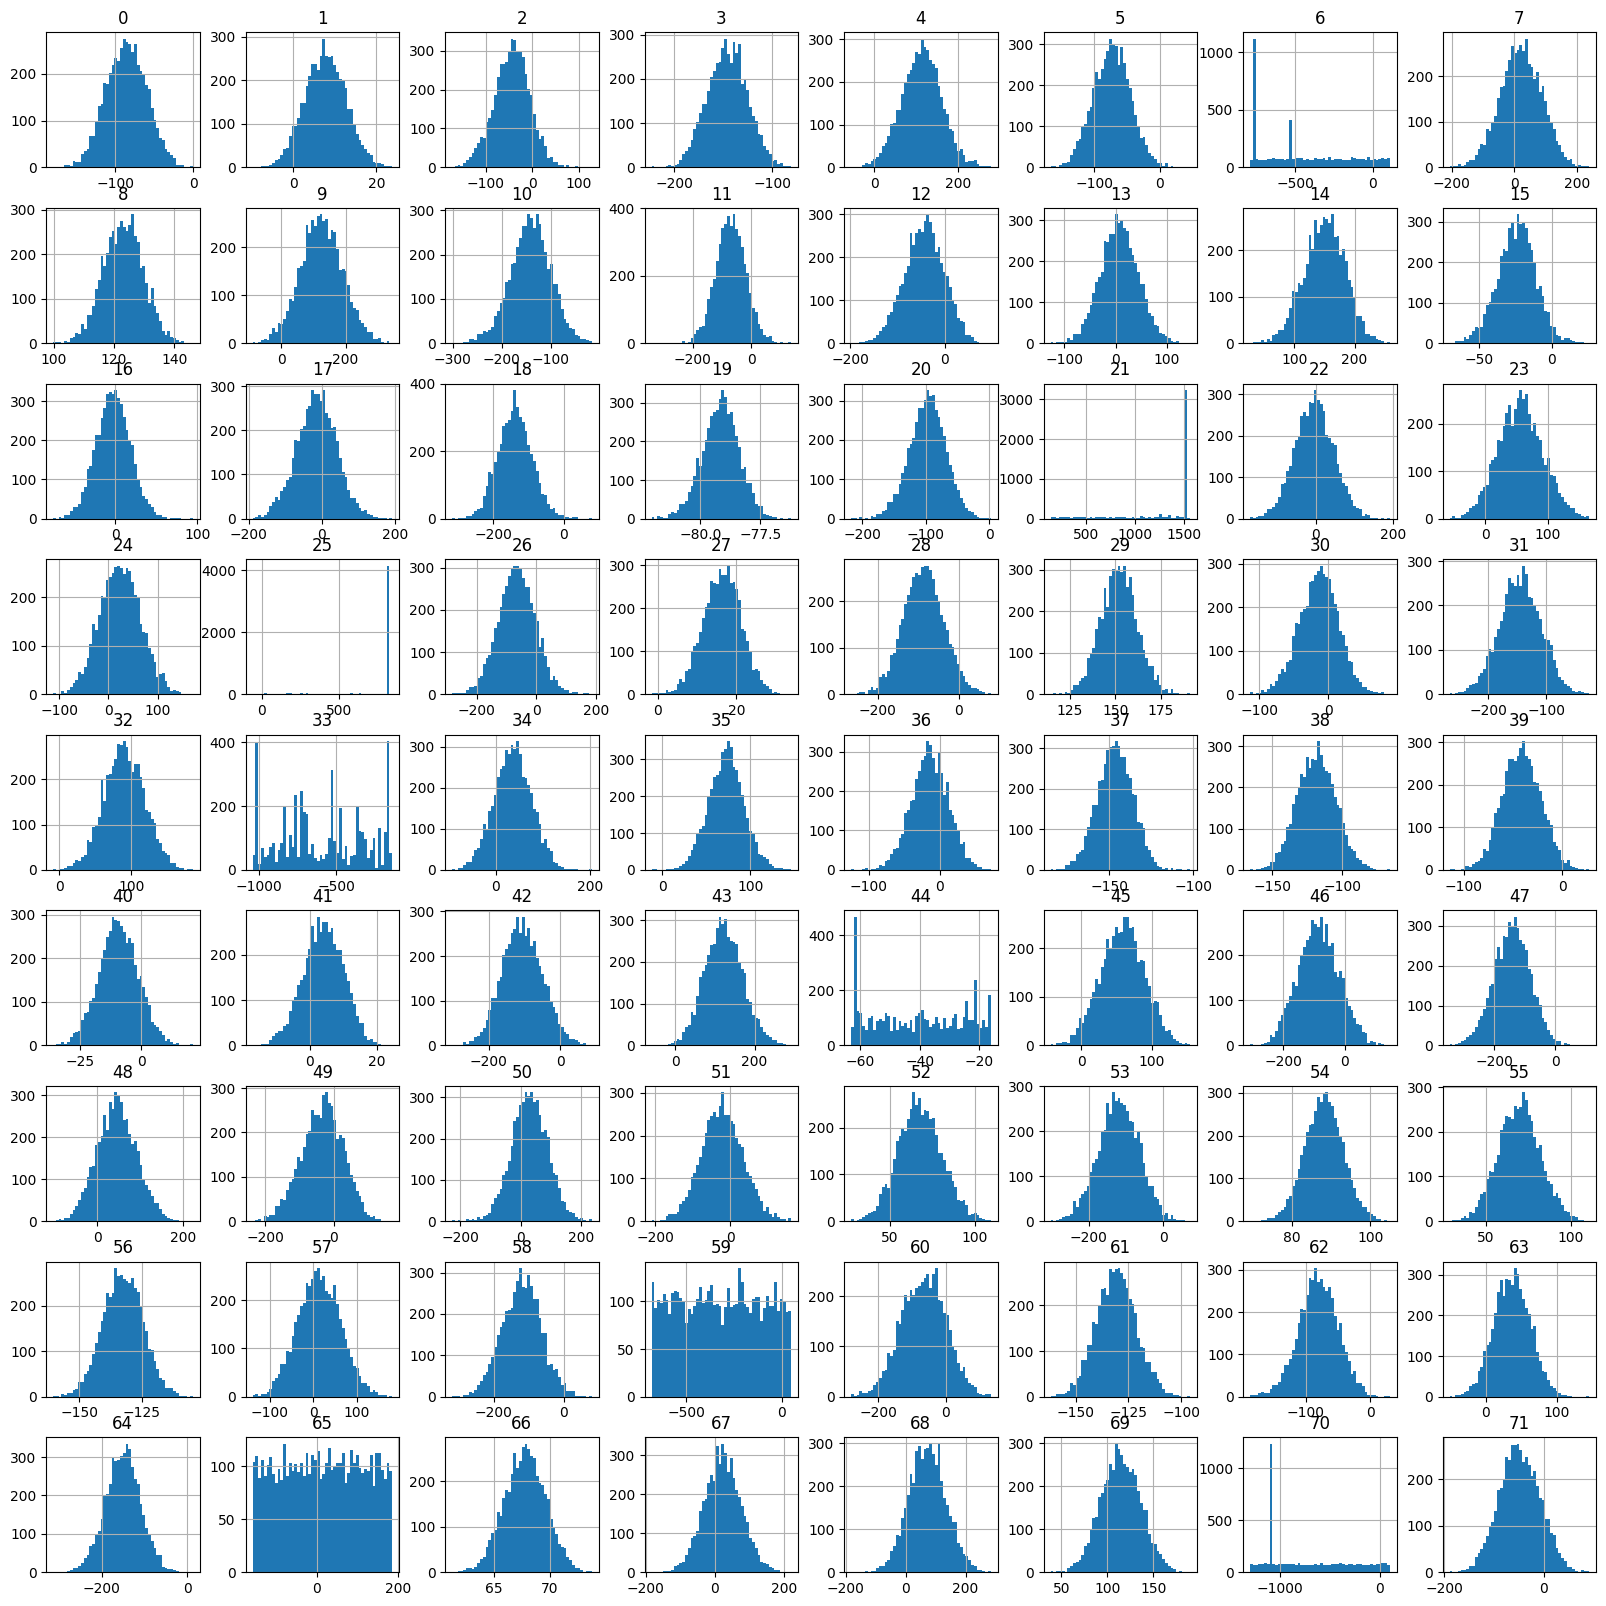

In [19]:
df_samples.hist(figsize=[20, 20], bins=50);

## Вторая модель

Нормализация данных

In [20]:
scaler = RobustScaler()
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)

dims = df_base2.shape[1]
# n_cells = 10
# how many cells
#quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)


In [21]:
idx_l2.train(np.ascontiguousarray(df_base2[:500, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))


In [22]:
2+3

5

In [23]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

53.823


## Третья модель

Проведём нормализацию данных с помощью StandardScaler, затем обучим ML-модель 'Faiss' и определим качество предсказаний с помощью метрики accuracy@5

In [24]:
st_scaler = StandardScaler()
df_base3 = st_scaler.fit_transform(df_base)
df_train3 = st_scaler.transform(df_train)

dims = df_base3.shape[1]
# n_cells = 10
# how many cells
#quantizer3 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [25]:
idx_l2.train(np.ascontiguousarray(df_base3[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base3).astype('float32'))

In [26]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train3).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.838


## Четвёртая модель

Проведем предобработку данных с целью улучшения качества предсказаний

In [27]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

df_samples.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.023775,0.027819,-0.013537,-0.024961,-0.019435,0.003612,-0.004606,-0.002295,-0.010452,-0.014417,0.034820,-0.001782,-0.005503,0.004069,-0.024439,-0.011285,0.001923,0.007464,0.018796,-0.004409,-0.006639,0.009296,-0.043258,-0.002267,0.017261,-0.017976,0.017811,0.014750,-0.009911,0.009931,-0.005787,-0.009366,0.026465,0.014051,0.029018,-0.019153,0.008803,0.023236,0.007132,-0.021245,-0.006155,0.006070,0.003616,0.029926,0.022260,0.034864,0.030954,-0.007946,-0.025152,0.008840,-0.016372,-0.019940,-0.043700,-0.004665,0.032257,0.051415,-0.028154,0.019489,-0.000097,0.041820,0.002107,0.007364,-0.018087,-0.014913,0.002341,-0.027277,-0.005696,-0.027131,-0.038355,-0.003569,-0.007428
1,0.023775,1.000000,-0.009389,0.024413,0.000990,-0.009717,0.013609,0.013737,-0.014300,0.022505,0.004379,-0.024587,0.004557,0.036455,0.001375,-0.027558,0.021059,0.035611,-0.007525,0.025127,0.034646,-0.013074,0.006919,0.013148,0.005392,-0.006273,0.014729,0.029743,-0.027632,0.004280,0.016789,0.021831,0.035779,0.007436,-0.015699,-0.010256,0.036124,0.016551,0.024157,0.026319,0.001934,0.016742,-0.017038,-0.012516,0.025470,-0.013706,-0.013722,-0.039135,-0.031832,-0.027659,0.005931,0.030032,-0.020079,-0.024940,-0.009019,0.021854,-0.009569,0.030426,-0.043426,-0.017882,-0.027103,-0.017414,0.000425,0.004398,-0.016150,-0.002836,0.003225,0.014522,-0.022561,0.015499,-0.001359,0.034421
2,0.027819,-0.009389,1.000000,-0.038877,-0.038310,-0.003156,-0.008980,-0.007762,0.019407,0.014040,0.000513,-0.008179,-0.017334,-0.017893,0.012996,0.011498,-0.000929,-0.013858,-0.015292,-0.047309,-0.019263,0.025754,0.004394,-0.000027,-0.019464,0.014337,0.003474,-0.018994,0.025674,0.036068,0.008126,0.007520,-0.002664,0.023160,-0.026050,0.004667,-0.015982,0.011277,0.028375,-0.051348,-0.021968,-0.038221,-0.000352,0.006268,0.026926,-0.015197,-0.027750,0.022720,0.026709,0.000710,0.021285,-0.000459,-0.046146,-0.009508,-0.044454,0.014192,-0.031510,-0.017693,0.010755,-0.014519,-0.012275,-0.035244,-0.045374,-0.026731,-0.018510,0.015895,-0.045242,-0.027843,-0.029056,0.010182,0.010644,0.007103
3,-0.013537,0.024413,-0.038877,1.000000,0.017614,-0.002149,-0.041670,0.020300,-0.000847,0.043355,0.004323,-0.022378,0.023653,0.022876,-0.025619,0.019960,-0.013806,0.001499,0.045132,-0.012002,0.015637,0.001281,0.037673,-0.008011,0.018066,-0.019394,0.033817,-0.018603,-0.026187,-0.020509,-0.011326,0.005759,0.022032,-0.011780,-0.009378,-0.028116,-0.022942,0.003280,-0.009077,-0.012011,0.015448,0.008626,0.019671,-0.025012,-0.019939,0.004918,0.020814,0.016333,-0.004723,-0.003055,0.032576,-0.017908,0.003660,0.054159,0.007914,-0.027613,-0.007426,0.008572,-0.013954,-0.022229,0.029456,0.008592,-0.006217,-0.015633,-0.005738,0.018921,0.001637,0.003325,0.013926,-0.019578,0.034284,0.024520
4,-0.024961,0.000990,-0.038310,0.017614,1.000000,0.009480,0.041856,-0.026057,-0.014100,0.020747,-0.026874,-0.008344,0.012891,0.021328,-0.015169,-0.057367,0.012488,0.000230,0.046744,-0.018162,-0.020355,-0.001886,0.006698,0.026941,0.001246,0.020188,0.010535,-0.017763,0.029461,0.003387,-0.018774,-0.006151,-0.019554,0.008966,-0.008141,-0.031463,0.041008,0.028673,0.012625,0.039494,0.038271,-0.011493,-0.007303,0.004705,0.022900,0.067864,-0.028169,-0.040896,-0.012216,-0.010880,-0.044253,0.017332,-0.048451,0.001183,0.007782,-0.038949,-0.018400,-0.005639,-0.002725,-0.004250,-0.009606,0.014687,0.013190,-0.016915,-0.012343,-0.001320,-0.025970,-0.010292,0.008229,-0.012566,0.007200,-0.009976
5,-0.019435,-0.009717,-0.003156,-0.002149,0.009480,1.000000,-0.036923,-0.000809,-0.018434,0.011490,-0.023253,-0.027099,-0.022465,0.007332,0.021987,0.027132,0.002872,-0.032484,0.026479,-0.024295,-0.014237,-0.031785,0.015858,0.024911,0.023564,0.001295,-0.025212,0.006648,-0.028558,-0.018954,0.003298,-0.006929,-0.001904,-0.033936,-0.014850,-0.004122,-0.018431,-0.0

Корреляция данных не выявила сильную зависимость данных *(это по модулю $>=$ 0.9)*

In [28]:
# df_samples3 = df_train3[:5000]
# df_samples3.hist(figsize=[20, 20], bins=50)
print(df_train3)

[[ 1.2995185   1.9968883   0.06377415 ...  0.9065746   0.9952668
   0.5229633 ]
 [-0.06214591 -0.25715932  0.32424858 ...  0.70945865 -0.6116897
  -0.08349096]
 [ 1.4563276  -0.85569566 -1.8517921  ...  0.30057627 -0.71384674
   0.6046772 ]
 ...
 [ 1.2968874  -0.67694914  0.39609632 ... -0.18653958  0.21909302
   1.0424612 ]
 [ 0.3578639   0.4118988  -0.50254726 ... -0.22969224 -0.71384674
  -0.75940657]
 [-0.11325188  0.5770834  -0.22327293 ... -0.70412666  1.9609631
  -0.7751664 ]]


Для обнаружения выбросов в данных используем ML-модель - Isolation Forest

In [29]:
%%time
model_IF = IsolationForest(n_estimators=100, 
                           max_samples='auto',
                           contamination=float(.01),
                           max_features=1.0,
                           random_state=STATE)
model_IF.fit(df_train)

CPU times: user 3.92 s, sys: 5.99 ms, total: 3.93 s
Wall time: 3.94 s


IsolationForest(contamination=0.01,
                random_state=RandomState(MT19937) at 0x7D4835BA5D40)

In [30]:
df_train['anomal_scores']=model_IF.decision_function(df_train)
# df_base['anomaly']=model_IF.predict(df_base)
print(df_train[['anomal_scores']].query('anomal_scores < 0').count())
# print(df_base[['anomal_scores']].shape[0])

anomal_scores    1000
dtype: int64


Удалим 1% данных с выбросами с обучающего датасета, а также столбец `anomal_scores`, который нам уже не нужен, т.к. он был необходим для обнаружения выбросов *(`animal_scores`$ < 0$)*

In [31]:
df_train_if = df_train.query('anomal_scores > 0')
df_train = df_train_if.drop('anomal_scores', axis = 1)
print(df_train.shape[0])

99000


In [32]:
df_train.index

Index(['0-query', '1-query', '2-query', '3-query', '4-query', '5-query',
       '6-query', '7-query', '8-query', '9-query',
       ...
       '99990-query', '99991-query', '99992-query', '99993-query',
       '99994-query', '99995-query', '99996-query', '99997-query',
       '99998-query', '99999-query'],
      dtype='object', name='Id', length=99000)

In [33]:
df_train = pd.concat([df_train, targets], axis=1, join='inner')
print(df_train.columns)
print(df_train.shape[0])

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')
99000


Снова разделим тренировочные данные на признаки и ответы

In [34]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Проведём нормализацию данных через standardscaler и 

In [35]:
st_scaler = StandardScaler()
df_base4 = st_scaler.fit_transform(df_base)
df_train4 = st_scaler.transform(df_train)

dims = df_base4.shape[1]
# n_cells = 10
# how many cells
quantizer4 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer4, dims, n_cells)

In [36]:
idx_l2.train(np.ascontiguousarray(df_base4[:350000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base4).astype('float32'))

In [37]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train4).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

55.852525252525254


## Пятая модель

В четвёртой модели была удалена часть данных с тренировочного датасета, поэтому вернём эти данные путём повторного чтения

In [38]:
df_base = pd.read_csv("/kaggle/input/datasets-for-matching/base.csv", index_col=0, dtype=dict_base)
df_train = pd.read_csv("/kaggle/input/datasets-for-matching/train.csv", index_col=0, dtype=dict_train)

В этой модели перемешаем обучающие данные

In [39]:
df_train_s = df_train.sample(frac=1, random_state=STATE)
df_train_s.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
99077-query,-87.487694,-4.032802,-59.182793,-154.972534,3.538773,-90.502617,54.664879,50.972183,126.033028,41.321968,-47.625648,-100.003578,-26.722820,-41.635025,150.051132,-20.605152,-10.463514,-75.651398,-110.898621,-77.464249,-23.477989,1507.231323,-54.655602,30.541843,-52.147083,813.770081,-1.235298,10.619465,-51.389484,160.283875,-16.828045,-195.266418,123.458893,-1018.469543,99.794571,63.293629,-31.110619,-134.603897,-115.106667,-49.188690,-9.472796,-2.389580,-73.049988,70.857452,-56.375927,55.105358,-126.158356,28.300232,36.045521,-1.474972,6.236992,-3.129878,80.110519,-176.710663,83.451630,69.053703,-122.779572,98.145592,-115.323448,-562.246643,-41.020668,-129.865936,-100.435432,-7.826923,-189.480057,-33.693573,71.094147,41.087509,57.515839,129.017761,-1029.568359,-25.466873,1624506-base
97716-query,-42.553223,11.093953,-130.538101,-173.518936,106.433685,-66.336388,-530.124695,27.698936,120.203735,211.748749,-140.126862,26.389870,-30.018238,-17.140285,151.388290,-21.152954,29.951725,-18.837261,-218.679642,-78.778412,-103.688805,264.777557,-23.966263,79.236069,15.233122,813.770081,-9.654087,22.204845,-67.087387,146.399689,-4.171525,-101.716888,106.217964,-709.451721,47.636665,93.007401,-3.967444,-146.511322,-123.623428,-21.358114,-29.194323,9.305656,-95.999924,40.589645,-57.423717,104.147026,-83.716209,-112.858322,47.642132,8.567123,91.320137,85.259842,78.397079,-159.901794,90.585861,59.326557,-138.595856,41.082901,-83.669769,-345.232849,-79.563637,-127.417290,-79.758530,27.726723,-173.424149,37.942451,70.667252,-49.056271,110.959282,115.388527,-1039.841797,-92.245300,144150-base
26977-query,-101.427727,14.071083,-66.258133,-166.366119,79.446671,-42.415867,-759.626038,-34.622261,130.327850,182.943848,-208.891541,-89.834969,9.052219,20.236536,88.029800,-29.391125,-34.660660,-11.623590,-201.084610,-78.958168,-87.424606,1235.098877,-49.832615,65.026909,-33.813164,813.770081,-259.470703,20.629601,-132.384430,161.771042,30.811249,-124.757950,37.532486,-323.035767,48.997883,66.981926,-31.856136,-125.397705,-138.436554,-35.082691,-9.647522,6.861538,-26.626724,91.457542,-38.016693,32.030758,-6.020485,-141.150131,62.531578,-65.462540,82.755783,-24.733801,68.981560,-106.260010,89.524483,64.428047,-138.025803,-5.051862,-292.098969,-153.147430,-91.420990,-129.059708,-88.246803,-4.021698,-173.104599,141.583191,69.015747,-53.224812,-19.989532,106.789032,-1132.519653,-11.081978,29570-base
16766-query,-51.944916,13.108861,-93.741356,-144.495346,102.713898,-55.682285,-726.816650,62.720238,118.723282,10.793137,-85.774292,4.528694,-15.608715,0.356080,103.082260,-38.427555,-18.334145,53.601612,-123.438095,-77.900581,-27.005554,1054.205566,12.077785,86.796539,107.024628,813.770081,8.225113,14.213449,-53.769093,143.031525,-2.777390,-104.142220,93.478622,-529.295044,95.837303,80.249329,-18.153286,-136.650406,-111.571754,-50.727295,-2.819665,1.503208,-165.048172,130.169800,-37.903275,125.529480,-58.308037,-135.966934,126.954285,-171.337051,109.155624,-71.399918,56.643257,-103.440376,84.132713,78.880013,-136.064407,33.928463,-89.345612,-414.106995,-36.428074,-134.315247,-58.323616,19.860699,-135.154266,-145.176514,68.499420,41.294426,51.982319,94.523376,-1.638165,-53.722279,2366964-base
61093-query,-107.441093,14.265862,-4.107307,-98.463448,80.833160,-37.486443,-93.274155,-17.090235,125.953682,63.801758,-116.521240,-47.959225,-10.966484,-35.859154,137.082367,-35.729721,20.037374,-3.330092,-96.282433,-79.800110,-91.558357,1507.231323,-34.988739,2.427483,-36.545753,813.770081,-110.204056,14.888170,-116.762901,143.696442,10.734315,-175.832230,96.527519,-481.586945,-25.084625,83.095490,-32.307632,-168.371353,-112.940063,-29.586945,-3.891303,15.660328,-66.056152,10

Напомним, в исходных обучающих данных был столбец с ответами, этот столбец надо выделить и, соответственно, удалить с датасета.

In [40]:
targets_s = df_train_s["Target"]
df_train_s.drop("Target", axis=1, inplace=True)

In [41]:
targets_s.head()

Id
99077-query    1624506-base
97716-query     144150-base
26977-query      29570-base
16766-query    2366964-base
61093-query    3887205-base
Name: Target, dtype: object

Проведём нормализацию данных с помощью StandardScaler, затем обучим ML-модель 'Faiss' и определим качество предсказаний с помощью метрики accuracy@5

In [42]:
df_base5 = st_scaler.fit_transform(df_base)
df_train5 = st_scaler.transform(df_train_s)

dims = df_base5.shape[1]
# n_cells = 10
# how many cells
#quantizer5 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [43]:
idx_l2.train(np.ascontiguousarray(df_base5[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base5).astype('float32'))

In [44]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train5).astype('float32'), k)

acc = 0
for target, el in zip(targets_s.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.838


## Шестая модель

Модель, аналогичная предыдущей, за исключением перемешивания базового датасета

In [45]:
df_base_s = df_base.sample(frac=1, random_state=STATE)

Проведём нормализацию данных с помощью StandardScaler, затем обучим ML-модель 'Faiss' и определим качество предсказаний с помощью метрики accuracy@5

In [46]:
df_base6 = st_scaler.fit_transform(df_base_s)
df_train6 = st_scaler.transform(df_train_s)

dims = df_base6.shape[1]
# n_cells = 10
# how many cells
#quantizer5 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [47]:
idx_l2.train(np.ascontiguousarray(df_base6[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base6).astype('float32'))

In [48]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train6).astype('float32'), k)

acc = 0
for target, el in zip(targets_s.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

0.0


Проведем общий анализ по 6 моделям

- Первая модель показала результат `acciracy@5`: $9.044$ 
- Во второй модели было принято решение нормализировать данные с помощью RobustScaler. Результат вышел следующим: $53.823$
- В третьей было аналогично, только нормализация *(точнее, стандартизация)* уже происходила с использованием метода StandardScaler: $65.838$ 
- В четвертой модели была проведена очистка аномальных данных через ML-модель - Isolation Forest *(Изолирующий лес)*, а дальше, как в третьей, нормализация. Получили результат: $55.853$
- В пятой модели перемешали тренировочные данные, остальные шаги повторили третью модель, Результат не изменился: $65.838$
- В шестой модели перемешали вдобавок ещё и базовые данные. Результат по нулям: $0.0$.

Соответственно, можем работать дальше с третьей или/и пятой моделью

Удалим переменные, чтобы освободить память

In [51]:
del df_base2
del df_train2
del df_base4
del df_train4
del df_base6
del df_train6

## CatBoost

Переходим к ML-модели CatBoost

In [53]:
2+3

5

In [59]:
model1 = CatBoostClassifier(
    iterations=100, depth=6, learning_rate=0.1,
   loss_function='MultiClass', verbose=False)
model1.fit(df_train3, targets)
preds_train1 = model1.predict(targets)

CatBoostError: Length of label=99000 and length of data=100000 is different.

Надо вспомнить, что над переменной *targets* происходили следующие операции: удаление аномалий из данных *(четвёртая модель)*. Вернём исходные значения.

In [62]:
df_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')

In [63]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)
print(df_train.head())
print(targets.head())

                 0          1           2           3           4           5  \
Id                                                                              
0-query -53.882748  17.971436  -42.117104 -183.936676  187.517487  -87.144928   
1-query -87.776367   6.806268  -32.054546 -177.260391  120.803329  -83.810593   
2-query -49.979565   3.841486 -116.118591 -180.401978  190.128433  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.011360   94.652840 -109.255409   
4-query -79.632126  14.442886  -58.903397 -147.052536   57.127068  -16.239529   

                  6          7           8           9          10  \
Id                                                                   
0-query -347.360596  38.307602  109.085564   30.413513  -88.082687   
1-query  -94.572746 -78.433090  124.915901  140.331070 -177.605804   
2-query   26.943937 -30.447489  125.771164  211.607819  -86.346558   
3-query -775.150146  79.186523  124.003098  242.650650 -146.517075   
4-query -321

**Попытка №2**

In [64]:
print(df_train3.shape, targets.shape)

(100000, 72) (100000,)


In [ ]:
model1 = CatBoostClassifier(
    iterations=100, depth=6, learning_rate=0.1,
   loss_function='MultiClass', verbose=False)
model1.fit(df_train3, targets)
preds_train1 = model1.predict(targets)

In [61]:
targets_s.shape

(100000,)

In [58]:
import sys
print(sys.getsizeof(targets)/(1024**2))

12.85421085357666


In [55]:
type(targets)

pandas.core.series.Series

In [ ]:
booster = CatBoostClassifier()

params = {
            'iterations':[5,10,50,100],
            'learning_rate':[0.01, 0.03, 0.1,1.0],
            'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS', 'No']
}

search_results = booster.randomized_search(params, df_train5, targets_s, cv=5, n_iter=12)

print("\nBest Params : ", search_results['params'])